In [1]:
from importlib.util import find_spec
%load_ext autoreload
%autoreload 2

%matplotlib inline

if find_spec("qml_hep_lhc") is None:
    import sys
    sys.path.append('../..')

In [189]:
from qml_hep_lhc.data import ElectronPhoton, MNIST, QuarkGluon
from qml_hep_lhc.data.utils import tf_ds_to_numpy, create_tf_ds
import argparse
import wandb

import pennylane as qml
import jax.numpy as jnp
import jax
import optax
from jax.nn.initializers import he_uniform, glorot_uniform
from jax import grad, jit, vmap
import random
import flax.linen as nn
import tensorflow_datasets as tfds
from tqdm import tqdm
import numpy as np
import tensorflow as tf


import matplotlib.pyplot as plt
import time

In [3]:
jax.devices()

[CpuDevice(id=0)]

In [308]:
args = argparse.Namespace()

# Data
args.center_crop = 0.7
args.resize = [8,8]
args.normalize = 1
args.binary_data = [0,1]
args.batch_size = 64
args.validation_split = 0.05
# args.labels_to_categorical = 1
# args.processed = 1

# Base Model
args.wandb = False

# Quantum CNN Parameters
args.n_layers = 1
args.n_qubits = 1
args.template = 'NQubitPQC'
args.initializer = 'he_uniform'
args.opt = 'adam'
args.margin = 1  # Margin for constrastive loss.

args.num_qconv_layers = 1
args.qconv_dims = [1]
args.kernel_sizes = [(3, 3)]
args.strides = [(1, 1)]
args.paddings = ["SAME"]

args.clayer_sizes = [8, 2]

In [309]:
if args.wandb:
     wandb.init(project='qml-hep-lhc', config = vars(args))

In [310]:
data = MNIST(args)
data.prepare_data()
data.setup()
print(data)

Binarizing data...
Binarizing data...
Center cropping...
Center cropping...
Resizing data...
Resizing data...
Normalizing data...

Dataset :MNIST
╒════════╤══════════════════╤════════════════╤═════════════════╤═══════════╕
│ Data   │ Train size       │ Val size       │ Test size       │ Dims      │
╞════════╪══════════════════╪════════════════╪═════════════════╪═══════════╡
│ X      │ (12031, 8, 8, 1) │ (634, 8, 8, 1) │ (2115, 8, 8, 1) │ (8, 8, 1) │
├────────┼──────────────────┼────────────────┼─────────────────┼───────────┤
│ y      │ (12031,)         │ (634,)         │ (2115,)         │ (1,)      │
╘════════╧══════════════════╧════════════════╧═════════════════╧═══════════╛

╒══════════════╤═══════╤═══════╤════════╤═══════╤══════════════════════════╕
│ Type         │   Min │   Max │   Mean │   Std │ Samples for each class   │
╞══════════════╪═══════╪═══════╪════════╪═══════╪══════════════════════════╡
│ Train Images │     0 │  0.82 │   0.07 │  0.11 │ [6405, 5626]             │
├─────

In [311]:
# x_train, y_train =  tf_ds_to_numpy(data.train_ds) 
# del data.train_ds

# x_val, y_val =  tf_ds_to_numpy(data.val_ds) 
# del data.val_ds

# x_test, y_test =  tf_ds_to_numpy(data.test_ds) 
# del data.test_ds

print(x_train.shape, x_val.shape, x_test.shape)

(12031, 8, 8, 1) (634, 8, 8, 1) (2115, 8, 8, 1)


In [312]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.
    """
    
    num_classes = len(data.config()['mapping'])
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

/home/gopald/Documents/qml-hep-lhc/qenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  from ipykernel import kernelapp as app


In [225]:
print(pairs_train.shape, pairs_val.shape, pairs_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

(1140, 2, 8, 8, 1) (60, 2, 8, 8, 1) (400, 2, 8, 8, 1)
(1140,) (60,) (400,)


In [313]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

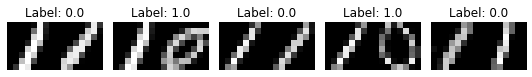

In [319]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=5, num_col=5)

In [320]:
data.train_ds = create_tf_ds(pairs_train, labels_train, args.batch_size)
data.val_ds = create_tf_ds(pairs_val,labels_val,  args.batch_size)
data.test_ds = create_tf_ds(pairs_test, labels_test, args.batch_size)

## Hyperparameters

In [321]:
input_dims = data.config()['input_dims']
input_dims

(8, 8, 1)

In [322]:
def get_out_shape(in_shape,f, k, s, padding):
    in_shape = (1,) + in_shape
    a = np.random.uniform(size = (in_shape))
    dn = jax.lax.conv_dimension_numbers(a.shape, (1,1,k[0],k[1]), ('NHWC', 'IOHW', 'NHWC'))
    out = jax.lax.conv_general_dilated_patches(lhs = a,
                                           filter_shape= k,
                                           window_strides=s,
                                           padding=padding,
                                           dimension_numbers=dn 
                                    )
    return out.shape[1:3]+(f,)

In [323]:
# Get qlayer sizes
def get_qlayer_sizes(template, n_l, n_q, k_size):
    if template == 'NQubitPQCSparse':
        return {
            'w': (n_l, n_q,3,np.prod(k_size)),
            'b': (n_l,n_q,3,1)
        }
    elif template == 'NQubitPQC':
        assert np.prod(k_size)%3 == 0
        return {
            'w': (n_l,n_q,np.prod(k_size)),
            'b': (n_l,n_q,np.prod(k_size))
        }

initializer = he_uniform()

In [324]:
def random_qlayer_params(size, key, filters, n_channels, scale=1e-1):
    w =  initializer(key, size)
    tile_shape = (filters,n_channels,) + (1,)*len(size)
    w = jnp.tile(w, tile_shape)
    return w

def init_qnetwork_params(in_shape, filters, kernel_size, strides, padding, template, n_l, n_q, key):
    n_channels = in_shape[-1]
    sizes = get_qlayer_sizes(template, n_l,n_q, kernel_size)
    keys = jax.random.split(key, len(sizes))
    return [random_qlayer_params(size, key, filters, n_channels) for size, key in zip(sizes.values(), keys)]

In [325]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_clayer_params(m, n, key, scale=1e-1):
    w_key, b_key = jax.random.split(key)
    return initializer(w_key, (n,m)), jax.random.normal(b_key, (n,))
    return scale * random.normal(w_key, (n, m)), scale * jax.random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_clayer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [326]:
num_qconv_layers = args.num_qconv_layers
qconv_dims = args.qconv_dims
kernel_sizes = args.kernel_sizes
strides = args.strides
paddings = args.paddings
clayer_sizes = args.clayer_sizes
margin = args.margin

template = args.template
n_layers = args.n_layers
n_qubits = args.n_qubits

In [327]:
in_shape = input_dims
params = []
for l in range(num_qconv_layers):
    qconv_params = init_qnetwork_params(in_shape, 
                                         qconv_dims[l], 
                                         kernel_sizes[l], 
                                         strides[l], 
                                         paddings[l],
                                         template, 
                                         n_layers,
                                         n_qubits,
                                         jax.random.PRNGKey(l))
    params += [qconv_params]
    in_shape = get_out_shape(in_shape,qconv_dims[l],kernel_sizes[l],strides[l],paddings[l])
    print(in_shape)
    

num_pixels = np.prod(in_shape)
clayer_sizes = [num_pixels] + clayer_sizes

params += init_network_params(clayer_sizes, jax.random.PRNGKey(2))
params += init_network_params([1,1], jax.random.PRNGKey(3))

(8, 8, 1)


/home/gopald/Documents/qml-hep-lhc/qenv/lib/python3.7/site-packages/jax/_src/lax/other.py:97: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  rhs = jnp.eye(spatial_size, dtype=lhs.dtype).reshape(filter_shape * 2)


In [328]:
for i in params:
    for j in i:
        print(j.shape, end = ' ')
    print()

(1, 1, 1, 1, 9) (1, 1, 1, 1, 9) 
(8, 64) (8,) 
(2, 8) (2,) 
(1, 1) (1,) 


## QLayers

In [329]:
dev = qml.device('default.qubit.jax', wires=n_qubits)
qubits =list(range(n_qubits))

@jax.jit
@qml.qnode(dev, interface='jax')
def NQubitPQCSparse(inputs, w, b):

    z = jnp.dot(w, jnp.transpose(inputs))+ b

    for q in qubits:
        qml.Hadamard(wires=q)
    
    for l in range(n_layers):
        for q in qubits:
            qml.Rot(z[l,q,0], z[l,q,1], z[l,q,2], wires= q)
        if (l & 1):
            for q0, q1 in zip(qubits[1::2], qubits[2::2] + [qubits[0]]):
                qml.CZ((q0,q1))
        else:
            for q0, q1 in zip(qubits[0::2], qubits[1::2]):
                qml.CZ((q0,q1))
   
    return qml.expval(qml.PauliZ(qubits[-1]))

In [330]:
dev = qml.device('default.qubit.jax', wires=n_qubits)
qubits =list(range(n_qubits))

@jax.jit
@qml.qnode(dev, interface='jax')
def NQubitPQC(inputs, w, b):
    steps = inputs.shape[-1]//3
    for q in qubits:
        qml.Hadamard(wires=q)
    
    for l in range(n_layers):
        for q in qubits:
            for i in range(steps):
                z = jnp.transpose(jnp.multiply(inputs[:,3*i:3*i+3],w[l,q,3*i:3*i+3]) + b[l,q,3*i:3*i+3])
                qml.RZ(z[0], wires=q)
                qml.RY(z[1], wires=q)
                qml.RZ(z[2], wires=q)
                
        if (l & 1):
            for q0, q1 in zip(qubits[1::2], qubits[2::2] + [qubits[0]]):
                qml.CZ((q0,q1))
        else:
            for q0, q1 in zip(qubits[0::2], qubits[1::2]):
                qml.CZ((q0,q1))

    return qml.expval(qml.PauliZ(qubits[-1]))

In [331]:
def get_node(template):
    if template == 'NQubitPQC':
        return NQubitPQC
    elif template == 'NQubitPQCSparse':
        return NQubitPQCSparse

In [332]:
def qconv_cop(x, w,b):
    end_dim = x.shape[-1]
    iters = x.shape[1:3]
    x = jnp.reshape(x , (-1,)+ (end_dim,))
    x = get_node(template)(x, w, b)
    x = jnp.reshape(x, (-1,) + iters)
    return x

batched_qconv_cop = vmap(qconv_cop, in_axes=(3, 0, 0))

def qconv_fop(x, w, b):
    x = batched_qconv_cop(x,w,b)
    x = jnp.sum(x, axis= 0)
    return x

batched_qconv_fop = vmap(qconv_fop, in_axes=(None,0,0))

def qconv(x, params, filters, kernel_size, stride, padding):
    n_channels = x.shape[-1]
    x = jnp.expand_dims(x,axis=0)
    dn = jax.lax.conv_dimension_numbers(x.shape, 
                                        (1,1,kernel_size[0],kernel_size[1]), 
                                        ('NHWC', 'IOHW', 'NHWC'))
    x = jax.lax.conv_general_dilated_patches(lhs = x,
                                               filter_shape= kernel_size,
                                               window_strides=stride,
                                               padding=padding,
                                               dimension_numbers=dn 
                                              )
    iters = x.shape[1:3]
    x = jnp.reshape(x, ((-1,) + iters + (n_channels,) + (np.prod(kernel_size),)))
    x = batched_qconv_fop(x, params[0], params[1])
    x = jnp.reshape(x, iters + (filters,))
    return x

In [333]:
random_flattened_image = jax.random.normal(jax.random.PRNGKey(1), input_dims)
random_flattened_image = jnp.floor(random_flattened_image*10)
random_flattened_image.shape

(8, 8, 1)

In [334]:
out = random_flattened_image
for l in range(num_qconv_layers):
    out = qconv(out, 
                params[l],
                qconv_dims[l], 
                kernel_sizes[l], 
                strides[l], 
                paddings[l])
    print(out.shape)

(8, 8, 1)


In [335]:
dev = qml.device("default.qubit", wires=n_qubits)
qnode = qml.QNode(get_node(template), dev)

inputs = np.random.uniform(size = (10,np.prod(kernel_sizes[0])))
weights = [params[0][0][0][0], params[0][1][0][0]]
drawer = qml.draw(qnode, expansion_strategy="device")
print(drawer(inputs,*weights))

0: ──H──RZ(M0)──RY(M1)──RZ(M2)──RZ(M3)──RY(M4)──RZ(M5)──RZ(M6)──RY(M7)──RZ(M8)─┤  <Z>


## Auto-Batching Predictions

In [336]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def sigmoid(x):
    return 1/(1+jnp.exp(-x))

def linear_forward(params, image):
    w, b = params
    return sigmoid(jnp.dot(w, image) + b)

def forward(params, image):
    # per-example predictions
    activations = image
    for l in range(num_qconv_layers):
        activations = qconv(activations, params[l], qconv_dims[l], kernel_sizes[l], strides[l], paddings[l])
        
    activations += image
    activations = relu(activations)
        
    activations = jnp.reshape(activations, (-1))
    for w, b in params[num_qconv_layers:-2]:
        outputs = jnp.dot(w, activations) + b
        activations = jnp.tanh(outputs)
    final_w, final_b = params[-2]
    logits = jnp.dot(final_w, activations) + final_b
    return jnp.tanh(logits)
#     return logits - logsumexp(logits)

In [337]:
# This works on single examples
preds = forward(params,  random_flattened_image)
print(preds)

[ 0.9995597 -0.9906562]


In [338]:
# Doesn't work with a batch
random_flattened_images = jax.random.normal(jax.random.PRNGKey(1), (2,)+ input_dims)
random_flattened_images = jnp.floor(random_flattened_images*10)
try:
    preds = forward(params, random_flattened_images)
except TypeError:
    print('Invalid shapes!')

Invalid shapes!


In [339]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_forward = vmap(forward, in_axes=(None,0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_forward(params, random_flattened_images)
print(batched_preds)

[[ 0.9995598 -0.9906517]
 [-0.9486237  0.812591 ]]


In [340]:
batched_sisters = vmap(batched_forward, in_axes=(None, 1))

In [341]:
batched_linear_forward = vmap(linear_forward, in_axes=(None, 0))

## Utility and loss functions

In [343]:
from sklearn.metrics import roc_auc_score

def accuracy(y_true, y_pred):
    target_class = jnp.argmax(y_true, axis=1)
    predicted_class = jnp.argmax(y_pred, axis=1)
    return jnp.mean(predicted_class == target_class)

def custom_accuracy(y_true, y_pred):
    y_pred = (y_pred >= 0.5)
    return jnp.mean(y_true == y_pred)

# Euclidean distance
@jit
def euclidean_distance(x, y):
    sum_square = jnp.sum(jnp.square(x-y), axis= 1, keepdims=True)
    return jnp.sqrt(jnp.maximum(sum_square, 1e-7))

@jit
def contrastive_loss(y_true, y_pred):
    square_pred = jnp.square(y_pred)
    margin_square = jnp.square(jnp.maximum(margin - (y_pred), 0))
    return jnp.mean((1 - y_true) * square_pred + (y_true) * margin_square)

def loss_fn(params, images, targets):
    
    preds_1, preds_2 = batched_sisters(params, images)
    merge = euclidean_distance(preds_1, preds_2)
    logits = batched_linear_forward(params[-1], merge)
    
    return contrastive_loss(logits, targets), logits

@jit
def update(opt_state, params, x, y):
    _ , grads = jax.value_and_grad(loss_fn, has_aux=True)(params, x, y)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return params, opt_state 

@jit
def step(params,x,y):
    loss_value, preds = loss_fn(params, x, y)
    acc = custom_accuracy(y, preds)
    return loss_value, acc

def evaluate(params, ds):
    losses = []
    accs = []
    with tqdm(tfds.as_numpy(ds), unit="batch") as tepoch:
        for x, y in tepoch:
            tepoch.set_description("Validation")
            loss_value, acc = step(params, x, y)
            losses.append(loss_value)
            accs.append(acc)
       
    return jnp.mean(np.array(losses)), jnp.mean(np.array(accs))

def predict(params, ds):
    preds = []
    y_true = []
    with tqdm(tfds.as_numpy(ds), unit="batch") as tepoch:
        for x, y in tepoch:
            preds += list(batched_forward(params, x))
            y_true += list(y)
    
    return np.array(preds), np.array(y_true)

## Training loop

In [344]:
import time

epochs = 50
N = 5
lr = 5e-2

epoch_times = []

for i in range(N):
    
    print('Learning Rate:', lr)

    optimizer = optax.rmsprop(learning_rate=lr)
    opt_state = optimizer.init(params)
    
    for epoch in range(epochs):
        start_time = time.time()

        with tqdm(tfds.as_numpy(data.train_ds), unit="batch") as tepoch:
            for x,y in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                params, opt_state = update(opt_state, params, x, y)

        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        loss, acc = evaluate(params, data.train_ds)
        val_loss, val_acc = evaluate(params, data.val_ds)

        print('loss: {} - acc: {}'.format(loss, acc))
        print('val_loss: {} - val_acc: {}'.format(val_loss, val_acc))
        print('time: {}'.format(epoch_time))

        if args.wandb:
            wandb.log({"accuracy": acc, 
                       "val_accuracy": val_acc, 
                       'loss':loss, 
                       'lr':lr,
                       'val_loss':val_loss})

    lr = lr*np.sqrt(0.1)

Learning Rate: 0.05


Validation: 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.33batch/s]


loss: 0.5000005960464478 - acc: 0.49999865889549255
val_loss: 0.49974462389945984 - val_acc: 0.5005409121513367
time: 42.13478946685791


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 187.94batch/s]


loss: 0.5000007152557373 - acc: 0.49999865889549255
val_loss: 0.4999059736728668 - val_acc: 0.5001803040504456
time: 2.127978563308716


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 182.38batch/s]


loss: 0.5000023245811462 - acc: 0.49999597668647766
val_loss: 0.4993751645088196 - val_acc: 0.5010817646980286
time: 2.1547951698303223


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 202.48batch/s]


loss: 0.5000025629997253 - acc: 0.49999597668647766
val_loss: 0.5 - val_acc: 0.5
time: 2.3018438816070557


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 217.94batch/s]


loss: 0.4999971389770508 - acc: 0.5000039935112
val_loss: 0.4989931285381317 - val_acc: 0.5014423131942749
time: 2.25329852104187


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 221.24batch/s]


loss: 0.5000019073486328 - acc: 0.4999973177909851
val_loss: 0.5001331567764282 - val_acc: 0.49981972575187683
time: 2.2747581005096436


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 213.01batch/s]


loss: 0.4999999701976776 - acc: 0.4999999701976776
val_loss: 0.500285804271698 - val_acc: 0.4996394217014313
time: 2.0793840885162354


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 212.03batch/s]


loss: 0.49999433755874634 - acc: 0.5000066757202148
val_loss: 0.4999999701976776 - val_acc: 0.5
time: 2.0675408840179443


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 211.12batch/s]


loss: 0.4999987781047821 - acc: 0.5000013113021851
val_loss: 0.4999999701976776 - val_acc: 0.5
time: 2.100806474685669


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 232.08batch/s]


loss: 0.5000108480453491 - acc: 0.499987930059433
val_loss: 0.49983707070350647 - val_acc: 0.5001803040504456
time: 2.0822222232818604


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 221.69batch/s]


loss: 0.49999499320983887 - acc: 0.5000053644180298
val_loss: 0.5008402466773987 - val_acc: 0.499098539352417
time: 2.0886223316192627


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 213.71batch/s]


loss: 0.499996155500412 - acc: 0.5000039935112
val_loss: 0.4988005757331848 - val_acc: 0.5012620091438293
time: 2.087437152862549


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 211.69batch/s]


loss: 0.49999868869781494 - acc: 0.5000013113021851
val_loss: 0.4996516704559326 - val_acc: 0.5003606081008911
time: 2.0895864963531494


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 219.17batch/s]


loss: 0.4999973177909851 - acc: 0.5000026822090149
val_loss: 0.499474436044693 - val_acc: 0.5005409121513367
time: 2.077139377593994


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 197.96batch/s]


loss: 0.49999865889549255 - acc: 0.5000013113021851
val_loss: 0.5003535151481628 - val_acc: 0.4996394217014313
time: 2.0870556831359863


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 214.35batch/s]


loss: 0.5000025629997253 - acc: 0.4999973177909851
val_loss: 0.5010658502578735 - val_acc: 0.4989182651042938
time: 2.081134557723999


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 213.29batch/s]


loss: 0.500005304813385 - acc: 0.4999946355819702
val_loss: 0.49946483969688416 - val_acc: 0.5005409121513367
time: 2.097684860229492


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 200.82batch/s]


loss: 0.5000013113021851 - acc: 0.49999865889549255
val_loss: 0.5000000596046448 - val_acc: 0.5
time: 2.0707414150238037


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 211.24batch/s]


loss: 0.5000026226043701 - acc: 0.4999973177909851
val_loss: 0.49928292632102966 - val_acc: 0.5007211565971375
time: 2.0920302867889404


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 213.63batch/s]


loss: 0.49999603629112244 - acc: 0.5000039935112
val_loss: 0.5000000596046448 - val_acc: 0.5
time: 2.103976011276245


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 209.20batch/s]


loss: 0.49999868869781494 - acc: 0.5000013113021851
val_loss: 0.4991017282009125 - val_acc: 0.500901460647583
time: 2.074338912963867


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 204.89batch/s]


loss: 0.4999906122684479 - acc: 0.5000093579292297
val_loss: 0.49946051836013794 - val_acc: 0.5005409121513367
time: 2.1040310859680176


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 201.43batch/s]


loss: 0.5000013709068298 - acc: 0.49999865889549255
val_loss: 0.49982014298439026 - val_acc: 0.5001803040504456
time: 2.088294506072998


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 198.45batch/s]


loss: 0.5000040531158447 - acc: 0.49999597668647766
val_loss: 0.5000001192092896 - val_acc: 0.5
time: 2.1029796600341797


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 202.95batch/s]


loss: 0.5000026822090149 - acc: 0.4999973177909851
val_loss: 0.5001800656318665 - val_acc: 0.49981972575187683
time: 2.106074333190918


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 209.32batch/s]


loss: 0.49999457597732544 - acc: 0.5000053644180298
val_loss: 0.49945980310440063 - val_acc: 0.5005409121513367
time: 2.0812106132507324


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 218.47batch/s]


loss: 0.5000013113021851 - acc: 0.49999865889549255
val_loss: 0.4996398389339447 - val_acc: 0.5003606081008911
time: 2.0440118312835693


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 212.05batch/s]


loss: 0.5000039935112 - acc: 0.49999597668647766
val_loss: 0.5000001788139343 - val_acc: 0.5
time: 2.0618796348571777


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 208.33batch/s]


loss: 0.4999959170818329 - acc: 0.5000039935112
val_loss: 0.5003601908683777 - val_acc: 0.4996394217014313
time: 2.0942094326019287


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 202.66batch/s]


loss: 0.4999973177909851 - acc: 0.5000026822090149
val_loss: 0.5 - val_acc: 0.5
time: 2.1069252490997314


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 217.88batch/s]


loss: 0.5000013113021851 - acc: 0.49999865889549255
val_loss: 0.5003603100776672 - val_acc: 0.4996394217014313
time: 2.103484869003296


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 180.12batch/s]


loss: 0.4999973177909851 - acc: 0.5000026822090149
val_loss: 0.4992794990539551 - val_acc: 0.5007211565971375
time: 2.1162421703338623


Validation: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.29batch/s]


loss: 0.4999973177909851 - acc: 0.5000026822090149
val_loss: 0.500180184841156 - val_acc: 0.49981972575187683
time: 2.2866461277008057


Epoch 33:  14%|█████████▎                                                       | 54/376 [00:00<00:02, 126.67batch/s]


KeyboardInterrupt: 

In [291]:
test_loss, test_acc = evaluate(params, data.test_ds)
test_loss, test_acc

Validation: 100%|█████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.25s/batch]


(DeviceArray(0.5014598, dtype=float32), DeviceArray(0.49759617, dtype=float32))

In [29]:
from sklearn.metrics import roc_auc_score

out,y_train = predict(params, data.train_ds)
train_auc = roc_auc_score(y_train, out)
train_auc

100%|███████████████████████████████████████████████████████████████████████████| 376/376 [00:34<00:00, 10.78batch/s]


0.9999998889953609

In [30]:
from sklearn.metrics import roc_auc_score

out,y_test = predict(params, data.test_ds)
test_auc = roc_auc_score(y_test, out)
test_auc

100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.56batch/s]


0.9996439809403939

In [98]:
if args.wandb:
    wandb.run.summary['test_loss'] = test_loss
    wandb.run.summary['test_acc'] = test_acc
    wandb.run.summary['test_auc'] = test_auc
    wandb.run.summary['train_auc'] = train_auc
    wandb.run.summary['avg_epoch_time'] = np.mean(np.array(epoch_times))
    y = y_test.argmax(axis=1)
    preds = out.argmax(axis=1)
    probs = out
    classes = data.mapping

    roc_curve = wandb.sklearn.plot_roc(y, probs, classes)
    confusion_matrix = wandb.sklearn.plot_confusion_matrix(y, preds, classes)

    wandb.log({"roc_curve": roc_curve})
    wandb.log({"confusion_matrix": confusion_matrix})
    wandb.finish()